Epoch [1/10], Step [10/469], Loss: 2.3130
Epoch [1/10], Step [20/469], Loss: 1.7800
Epoch [1/10], Step [30/469], Loss: 1.2947
Epoch [1/10], Step [40/469], Loss: 1.1651
Epoch [1/10], Step [50/469], Loss: 0.7558
Epoch [1/10], Step [60/469], Loss: 0.8122
Epoch [1/10], Step [70/469], Loss: 0.7531
Epoch [1/10], Step [80/469], Loss: 0.6310
Epoch [1/10], Step [90/469], Loss: 0.7291
Epoch [1/10], Step [100/469], Loss: 0.6423
Epoch [1/10], Step [110/469], Loss: 0.6199
Epoch [1/10], Step [120/469], Loss: 0.7290
Epoch [1/10], Step [130/469], Loss: 0.5067
Epoch [1/10], Step [140/469], Loss: 0.6634
Epoch [1/10], Step [150/469], Loss: 0.6045
Epoch [1/10], Step [160/469], Loss: 0.5454
Epoch [1/10], Step [170/469], Loss: 0.5396
Epoch [1/10], Step [180/469], Loss: 0.6932
Epoch [1/10], Step [190/469], Loss: 0.5064
Epoch [1/10], Step [200/469], Loss: 0.4998
Epoch [1/10], Step [210/469], Loss: 0.5660
Epoch [1/10], Step [220/469], Loss: 0.6122
Epoch [1/10], Step [230/469], Loss: 0.5405
Epoch [1/10], Step [

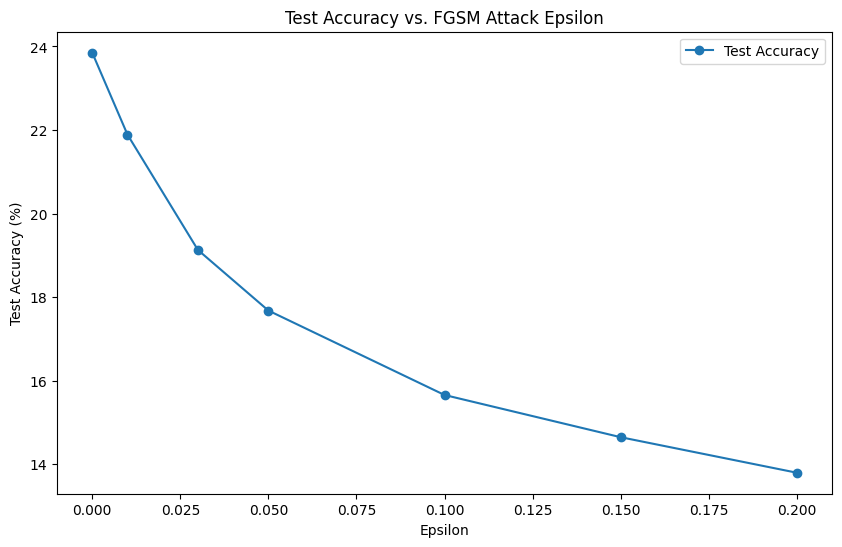

Adversarial Retrain Epoch [1/10], Step [10/469], Loss: 0.7118
Adversarial Retrain Epoch [1/10], Step [20/469], Loss: 0.6942
Adversarial Retrain Epoch [1/10], Step [30/469], Loss: 0.4652
Adversarial Retrain Epoch [1/10], Step [40/469], Loss: 0.5447
Adversarial Retrain Epoch [1/10], Step [50/469], Loss: 0.3850
Adversarial Retrain Epoch [1/10], Step [60/469], Loss: 0.4422
Adversarial Retrain Epoch [1/10], Step [70/469], Loss: 0.4423
Adversarial Retrain Epoch [1/10], Step [80/469], Loss: 0.5385
Adversarial Retrain Epoch [1/10], Step [90/469], Loss: 0.4920
Adversarial Retrain Epoch [1/10], Step [100/469], Loss: 0.4217
Adversarial Retrain Epoch [1/10], Step [110/469], Loss: 0.4696
Adversarial Retrain Epoch [1/10], Step [120/469], Loss: 0.3256
Adversarial Retrain Epoch [1/10], Step [130/469], Loss: 0.3753
Adversarial Retrain Epoch [1/10], Step [140/469], Loss: 0.3800
Adversarial Retrain Epoch [1/10], Step [150/469], Loss: 0.4276
Adversarial Retrain Epoch [1/10], Step [160/469], Loss: 0.3511
A

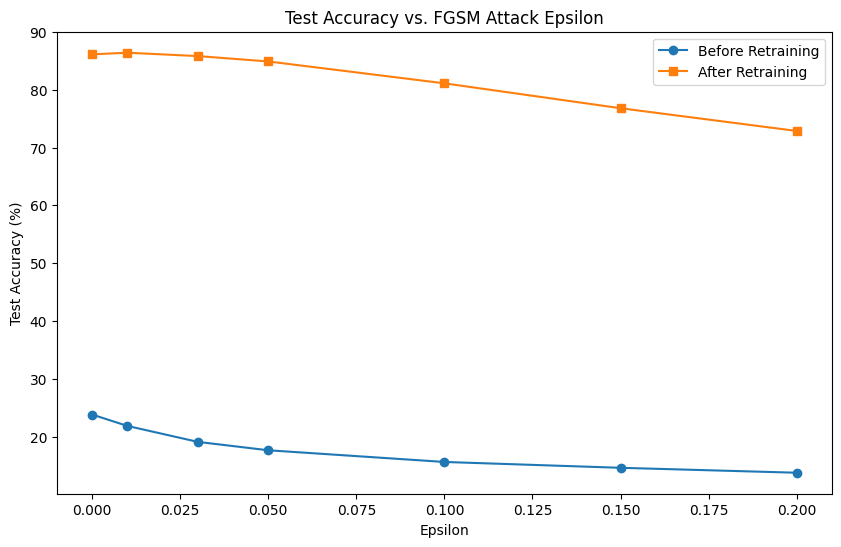

In [1]:
#FGSM Attack and Defend Methods on AlexNet

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt

num_epochs = 10
batch_size = 128
learning_rate = 0.001
epsilon_values = [0, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_indices = random.sample(range(len(train_dataset)), len(train_dataset))
test_indices = random.sample(range(len(test_dataset)), len(test_dataset))

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False)

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)
        x = self.classifier(x)
        return x

model = AlexNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

def test_model(data_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print(f'Accuracy on the clean test set: {test_model(test_loader):.2f}%')


# FGSM Attack

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    perturbed_images = images + epsilon * images.grad.sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)  
    return perturbed_images

accuracies = []

for epsilon in epsilon_values:
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    accuracies.append(accuracy)
    print(f"Epsilon: {epsilon:.2f}, Test Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o', label='Test Accuracy')
plt.title('Test Accuracy vs. FGSM Attack Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()


# Defend Method

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon=0.03)

        combined_images = torch.cat([images, adv_images], dim=0)
        combined_labels = torch.cat([labels, labels], dim=0)

        outputs = model(combined_images)
        loss = criterion(outputs, combined_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Adversarial Retrain Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print(f'Accuracy on the clean test set after adversarial retraining: {test_model(test_loader):.2f}%')

accuracies_after_retrain = []

for epsilon in epsilon_values:
    total_correct = 0
    total_samples = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        adv_images = fgsm_attack(model, images, labels, epsilon)

        outputs = model(adv_images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = 100 * total_correct / total_samples
    accuracies_after_retrain.append(accuracy)
    print(f"Epsilon: {epsilon:.2f}, Test Accuracy after Retraining: {accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, accuracies, marker='o', label='Before Retraining')
plt.plot(epsilon_values, accuracies_after_retrain, marker='s', label='After Retraining')
plt.title('Test Accuracy vs. FGSM Attack Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()
